## Anchor Boxes
Different models may adopt different region sampling schemes. We introduce one of such methods: it generates multiple bounding boxes with varying scales and aspect ratios centered on each pixel. These bounding boxes are called anchor boxes.

We define:
* `h` and `w`: height and width of the input image
* `s`: scale in (0,1]
* `r`: aspect ratio width/height > 0, different shape of anchor box. r = 1 is square
* `width of anchor box`: w*s*(r**0.5)
* `height of anchor box`: h*s/(r**0.5)
* `S` = s1,...,sn: different scale
* `R` = r1,...,rm: different aspect ratio

We use all `S` and `R` combinations with each pixel as the center, the input image will have a total of `w*h*n*m` anchor boxes. The computational complexity is too high. So in practice we can only consider those combinations: (s1, r1),(s1, r2),...,(s1,rm),(s2, r1),(s3,r1),...,(sn,r1).

The number of anchor boxes is  `n + m - 1`  with each pixel and `w*h*(n+m-1)` with the input image.

torch.Size([3, 375, 500]) torch.Size([1, 750000, 4])
tensor([[0.6135, 0.3380, 0.9885, 0.8380],
        [0.7072, 0.4630, 0.8947, 0.7130],
        [0.5714, 0.3839, 1.0306, 0.7921],
        [0.6684, 0.2344, 0.9336, 0.9416]])
tensor([[306.7500, 126.7500, 494.2500, 314.2500],
        [353.6250, 173.6250, 447.3750, 267.3750],
        [285.6802, 143.9534, 515.3198, 297.0466],
        [334.2087,  87.9175, 466.7913, 353.0825]])


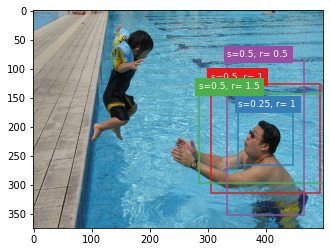

In [51]:
import torch
from cv.utils.anchorbox import multibox_prior
from contants import VOC_TRAIN_DIR
import os
from PIL import Image
import torchvision
from img import img_withbox

img_file_name = "2012_004331"
img_file = os.path.join(VOC_TRAIN_DIR,"JPEGImages",img_file_name+".jpg")

to_tensor = torchvision.transforms.ToTensor()
img = to_tensor(Image.open(img_file))

X = torch.rand(img.shape).unsqueeze(0)
sizes, ratios = [0.5, 0.25],[1, 1.5, 0.5]
# `multibox_prior`
Y = multibox_prior(X,sizes,ratios)
print(img.shape, Y.shape)

h, w = img.shape[-2:]
img_scale = torch.tensor((w, h, w, h))
boxes = Y.reshape(h, w, -1, 4)
# Get one box at (250, 250) with (s1, r1)
anchor_boxes = boxes[220, 400, :, :]
print(anchor_boxes)
scaled_boxes = anchor_boxes * img_scale
print(scaled_boxes)

tags = []
tags += [f"s={s}, r= {ratios[0]}" for s in sizes]
tags += [f"s={sizes[0]}, r= {r}" for r in ratios[1:]]

res = img_withbox(img_file, scaled_boxes.tolist(), tags)

## Intersection over Union (IoU)
We usually refer Jaccard index of two boxes as intersection over union (IoU).


In [52]:
# `iou`
from cv.metrics.iou import iou

boxes1 = torch.rand(2,4)
boxes2 = torch.rand(5,4)

scores = iou(boxes1, boxes2)
print(scores.shape)
scores

torch.Size([2, 5])


tensor([[0., -0., -0., 0., -0.],
        [-0., -0., -0., -0., -0.]])

### Training
Each anchor box as a training example.
1. class: Give each anchor box a label.
2. offset: Offset of an anchor box to its correspond ground-truth box.

#### Assigning Gound-Truth Bounding Boxes to Anchor Boxes
Each anchor box will be assigned a class. If not matched any label with the criteria, it will be considered as a background class.

In [53]:
from cv.utils.anchorbox import assign_anchor

anchors = torch.randint(1,10,(5,4))
ground_truth_boxes = torch.randint(2,5, (3,4))

assign_anchor(anchors, ground_truth_boxes)

tensor([ 2, -1,  1,  0, -1])

#### Offsets
For any anchor **A** and its assigned ground-truth label **B** we get the central coordinate position and size offsets.

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$



In [54]:
from cv.utils.anchorbox import *

anchors, assigned = torch.rand(3,4), torch.rand(3,4)
offset(anchors, assigned).shape

torch.Size([3, 4])

#### Put all together


In [55]:
def multibox_target(anchors, labels):
    """Get the offset, anchor class mask and anchor class of anchors to each batch of labels.
        Use class index 0 as background class index. Other class index add up 1.
    :param anchors: (M, 4)
    :param labels: (B, N, 5), each label (class, x1,y1,x2,y2)
    :return: (offset(B, M, 4), class_mask(B, M, 4), class(B, M))
    """
    anchors = anchors.squeeze(0)
    anchor_size = anchors.shape[0]
    classes_batch, mask_batch, offsets_batch = [],[],[]

    for i in range(labels.shape[0]):
        label = labels[i] # (N, 5)
        assigned = assign_anchor(anchors, label[:, 1:]) # (M,). Assigned label index, not class id.

        anchor_indices = assigned>=0
        label_indices = assigned[anchor_indices]
        
        # 1. classes
        classes = torch.zeros((anchor_size,), device = anchors.device, dtype = torch.long) #(M, )
        classes[anchor_indices] = label[label_indices, 0].long() + 1 # 0 is background

        # 2. mask
        mask = (assigned>=0).float().reshape(-1,1).repeat(1,4) # (M,4)

        # 3. offset
        label_boxes = torch.zeros((anchor_size,4), device = anchors.device)
        label_boxes[anchor_indices] = label[label_indices, 1:]
        offsets = offset(anchors, label_boxes) * mask #(M,4)

        classes_batch.append(classes)
        mask_batch.append(mask.reshape(-1))
        offsets_batch.append(offsets.reshape(-1))

    return [torch.stack(it) for it in (offsets_batch, mask_batch, classes_batch)]        
    


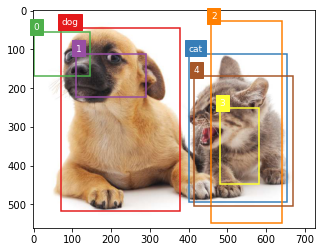

In [56]:
from PIL import Image

ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

img = "cv/tutorial/assets/catdog.jpg"
h, w= to_tensor(Image.open(img)).shape[-2:]
img_scale = torch.tensor((w, h, w, h))

res = img_withbox(img, 
            (ground_truth[:,1:] * img_scale).tolist() + (anchors * img_scale).tolist(),
            ["dog", "cat"] + list(range(0, len(anchors))))

In [57]:
labels = multibox_target(anchors.unsqueeze(dim = 0), ground_truth.unsqueeze(dim=0))

# classes
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [58]:
# mask
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [59]:
# offset
labels[0]

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
          1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]])

### Prediction and Non-maximum Suppress (NMS)


In [60]:
from cv.utils.nms import nms


def multibox_detection(class_predicts: torch.Tensor, predicted_offset: torch.Tensor,
                        anchors, nms_threshold=0.5, pos_threshold=.009999999):
    """Get predicted result from class distribution and offset prediction.
    :param class_predicts: (B, C, A)
    :param predicted_offset: (B, A * 4)
    :param anchors: (1, A, 4)
    :param return: (B, A, 6(class, prob/confident, box))
    """                    
    batch_size = class_predicts.shape[0]
    anchors = anchors.squeeze(0) # batch size = 1, All batches share one.

    res = []
    for i in range(batch_size):
        # Get the predicts
        class_prob = class_predicts[i][1:] # (C, A), discard background class, means every class id minus 1.
        conf, class_idx = class_prob.T.max(dim = -1) # (A, )
        predict_boxes = offset_inverse(anchors, predicted_offset[i].reshape(-1,4))
        keep_idx = nms(predict_boxes, conf, nms_threshold) # (X, 4)

        # Only preserve the keep indices, others means background.
        keep_class_idx = class_idx[keep_idx]
        class_idx[:] = -1
        class_idx[keep_idx] = keep_class_idx

        # Less than pos_threshold means background
        class_idx[conf<pos_threshold] = -1
        conf[conf<pos_threshold] = 1 - conf[conf<pos_threshold]

        #TODO: Pull keep_idx up to head

        predict = torch.cat((class_idx.reshape(-1, 1), conf.reshape(-1, 1), predict_boxes), dim = -1)
        res.append(predict)
    
    return torch.stack(res)
        



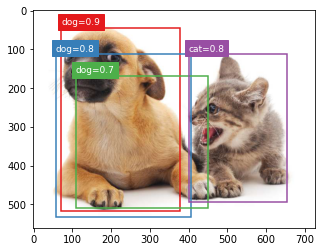

In [61]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.8]])  # Predicted cat likelihood

res = img_withbox(img, anchors * img_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.8'])

In [62]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.8000,  0.5500,  0.2000,  0.9000,  0.8800]]])

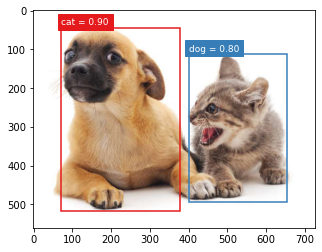

In [63]:
output = output.squeeze(0)
boxes, titles = [], []
for i in range(output.shape[0]):
    predict = output[i]
    if predict[0]<0:
        continue
    
    boxes.append(predict[-4:])
    tag = ["cat","dog"][int(predict[0].item())]
    titles.append(f"{tag} = {predict[1]:.2f}")

res = img_withbox(img, torch.stack(boxes) * img_scale, titles)
    